# M/EEG exam instructions
- Assignment format: 
    - mandatory: a notebook with your answers 
    - optional: an additional document with your answers to the conceptual questions
- Please send your assignment to M.Corsi's email address
- Deadline: 
    - **Feb 22nd, 8AM.** Please not that an **extension will not be proposed.**

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.time_frequency import tfr_multitaper
from mne_connectivity import spectral_connectivity_epochs


C:\Users\yonau\AppData\Local\Temp\ipykernel_3884\2589654060.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Part 1 - Connectivity and Networks

Here is an EEG dataset to load:

In [46]:
 #Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # Motor imagery: hands vs feet

# Extract raw data
fnames = eegbci.load_data(subject=subject, runs=runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])
raw.rename_channels(lambda x: x.strip("."))  # remove dots from channel names
events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))
channel_names = raw.info['ch_names']

# Extract trials between -1s and 4s
tmin, tmax = -1, 4
event_ids = dict(hands=2, feet=3)  # map event IDs to tasks
epochs = mne.Epochs(
    raw,
    events,
    event_ids,
    tmin - 0.5,
    tmax + 0.5,
    baseline=None,
    preload=True,
)

Extracting EDF parameters from c:\Users\yonau\Desktop\MVA\S2\Brain functional Imaging\M2-MVA_MEEG_hands-on_materials-main\M2-MVA_MEEG_hands-on_materials-main\datasets\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from c:\Users\yonau\Desktop\MVA\S2\Brain functional Imaging\M2-MVA_MEEG_hands-on_materials-main\M2-MVA_MEEG_hands-on_materials-main\datasets\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from c:\Users\yonau\Desktop\MVA\S2\Brain functional Imaging\M2-MVA_MEEG_hands-on_materials-main\M2-MVA_MEEG_hands-on_materials-main\datasets\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R14.edf...
EDF file detected
Setting channel info structure..

In [47]:
epochs_hands = mne.Epochs(
    raw,
    events,
    event_ids['hands'],
    tmin - 0.5,
    tmax + 0.5,
    baseline=None,
    preload=True,
)
epochs_feet = mne.Epochs(
    raw,
    events,
    event_ids['feet'],
    tmin - 0.5,
    tmax + 0.5,
    baseline=None,
    preload=True,
)

print(epochs_hands)
print(epochs_feet)

Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 961 original time points ...
0 bad epochs dropped
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 961 original time points ...
0 bad epochs dropped
<Epochs |  21 events (all good), -1.5 – 4.5 s, baseline off, ~9.9 MB, data loaded,
 '2': 21>
<Epochs |  24 events (all good), -1.5 – 4.5 s, baseline off, ~11.3 MB, data loaded,
 '3': 24>


In [48]:
data = raw.get_data()
data.shape

(64, 60000)

## Questions:
- For each condition:
    - Compute and plot the connectivity matrices based on the estimation of the imaginary coherence averaged over the mu band and across the epochs. What does it say about potential changes between the tasks performed by the subject?
    - Compute and plot the associated node strength averaged across the epochs. What does it say about potential changes between the tasks performed by the subject?

- Here is the plot of the statistical difference between MI and Rest conditions obtained from imaginary coherence (left) and the results obtained with the node strength (right): What do you observe? Is it neurophysiologically meaningful?
![Figure_ImCoh](./MI_Rest_ImCoh.png)


In [49]:
fmin = 8
fmax = 13
sfreq = raw.info['sfreq']  # the sampling frequency
con_methods = ['imcoh'] # imcoh is a method for computing the imaginary part of coherency

# Compute connectivity for the hands condition
con_hands = spectral_connectivity_epochs(
    epochs_hands,
    method=con_methods,
    mode='multitaper',
    sfreq=sfreq,
    fmin=fmin,
    fmax=fmax,
    faverage=True,  #faverage= True to average over frequencies
    mt_adaptive=False, #mt_adaptive= False to use a fixed number of tapers
    n_jobs=1, #n_jobs= 1 to use only one CPU
    verbose=True, #verbose= True to display progress
)

# Compute connectivity for the feet condition
con_feet = spectral_connectivity_epochs(
    epochs_feet,
    method=con_methods,
    mode='multitaper',
    sfreq=sfreq,
    fmin=fmin,
    fmax=fmax,
    faverage=True,  #faverage= True to average over frequencies
    mt_adaptive=False, #mt_adaptive= False to use a fixed number of tapers
    n_jobs=1, #n_jobs= 1 to use only one CPU
    verbose=True, #verbose= True to display progress
)

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2016 connections
    using t=-1.500s..4.500s for estimation (961 points)
    frequencies: 8.2Hz..13.0Hz (30 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Imaginary Coherence
    computing cross-spectral density for epoch 1


    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    computing cross-spectral density for epoch 21
    asse

In [50]:
# Get the connectivity data
con_hands_data = con_hands.get_data()
con_feet_data = con_feet.get_data()

print("****************************")
print(con_hands)
print(con_hands_data.shape)
print("****************************")
print(con_feet)
print(con_feet_data.shape)

****************************
<SpectralConnectivity | freq : [10.572320, 10.572320], , nave : 21, nodes, n_estimated : 64, 4096, ~68 kB>
(4096, 1)
****************************
<SpectralConnectivity | freq : [10.572320, 10.572320], , nave : 24, nodes, n_estimated : 64, 4096, ~68 kB>
(4096, 1)


In [51]:
 # Reshape the connectivity data in 64 x 64 matrices
con_hands_data = con_hands_data.reshape(64, 64)
con_feet_data = con_feet_data.reshape(64, 64)

In [52]:
print("****************************")
print(con_hands_data.shape)
print("****************************")
print(con_feet_data.shape)

****************************
(64, 64)
****************************
(64, 64)


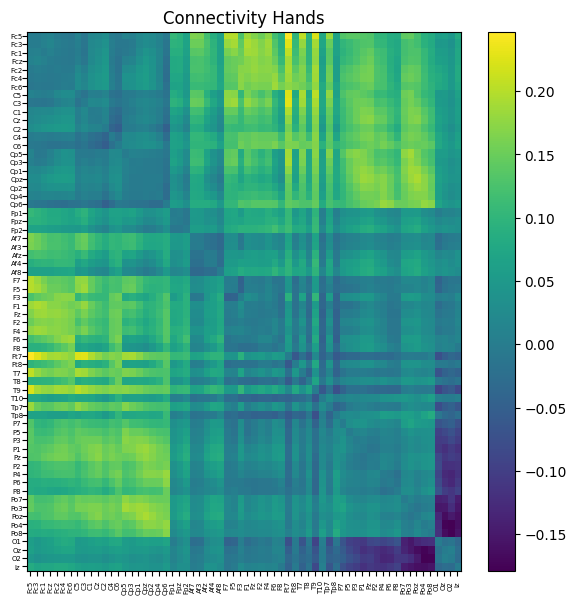

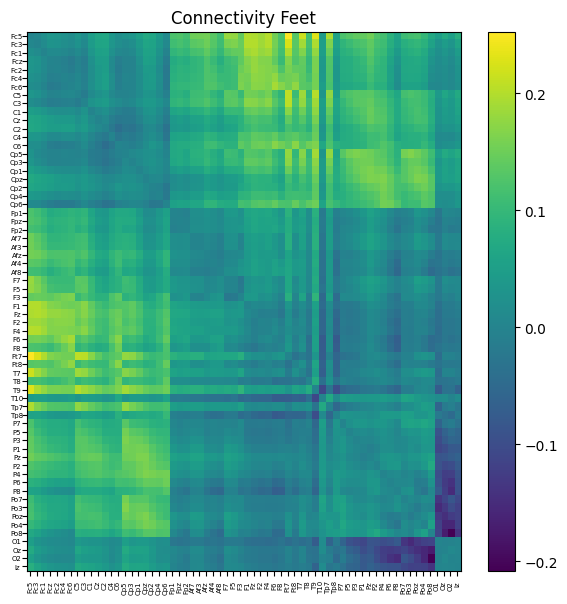

In [57]:
# get the transpose of the connectivity data
con_hands_dataT = con_hands_data.T
con_feet_dataT = con_feet_data.T

plt.figure(figsize=(7, 7))
plt.imshow(con_hands_data + con_hands_dataT, cmap='viridis', aspect='auto')
plt.title('Connectivity Hands')
# separate evenly the ticks

plt.xticks(range(len(channel_names)), channel_names, rotation=90, fontsize= 5, linespacing= 10, fontstretch='ultra-expanded', ha='center')
plt.yticks(range(len(channel_names)), channel_names, fontsize= 5, linespacing= 10, fontstretch='ultra-expanded', ha='center')
plt.colorbar()
plt.show()

plt.figure(figsize=(7, 7))
plt.imshow(con_feet_data + con_feet_dataT, cmap='viridis', aspect='auto')
plt.title('Connectivity Feet')
# separate evenly the ticks

plt.xticks(range(len(channel_names)), channel_names, rotation=90, fontsize= 5, linespacing= 10, fontstretch='ultra-expanded', ha='center')
plt.yticks(range(len(channel_names)), channel_names, fontsize= 5, linespacing= 10, fontstretch='ultra-expanded', ha='center')
plt.colorbar()
plt.show()


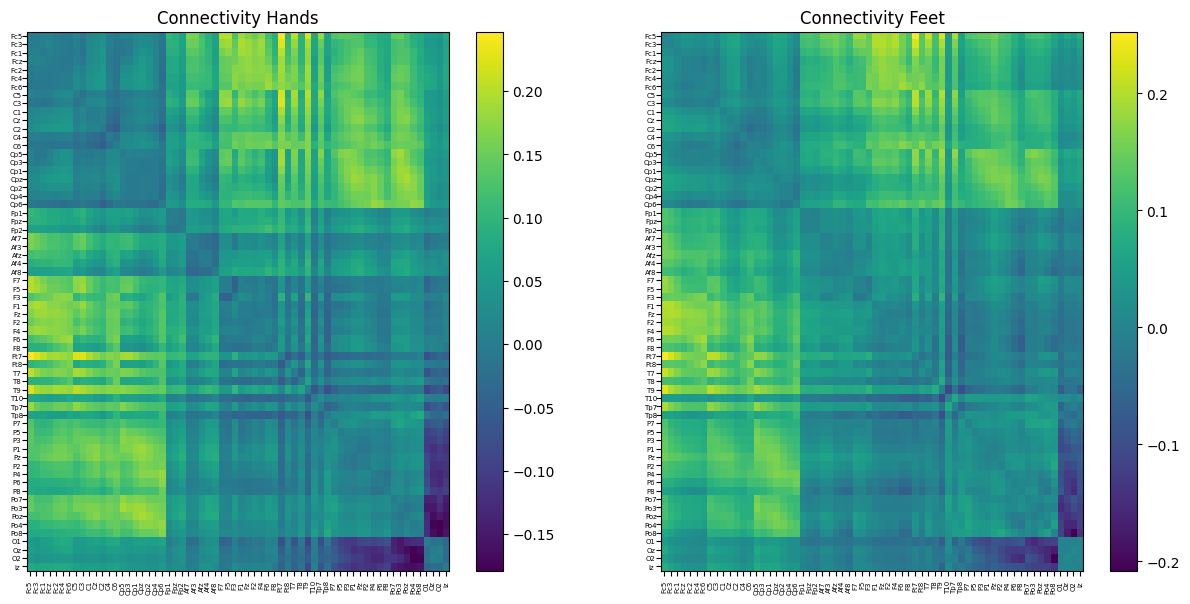

In [58]:
# Plot the connectivity for both conditions (hands and feet)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
im = ax[0].imshow(con_hands_data + con_hands_dataT, cmap='viridis', aspect='auto')
ax[0].set_title('Connectivity Hands')
ax[0].set_xticks(range(len(channel_names)))
ax[0].set_xticklabels(channel_names, rotation=90, fontsize= 5, linespacing= 10, fontstretch='ultra-expanded', ha='center')
ax[0].set_yticks(range(len(channel_names)))
ax[0].set_yticklabels(channel_names, fontsize= 5, linespacing= 10, fontstretch='ultra-expanded', ha='center')
fig.colorbar(im, ax=ax[0])

im = ax[1].imshow(con_feet_data + con_feet_dataT, cmap='viridis', aspect='auto')
ax[1].set_title('Connectivity Feet')
ax[1].set_xticks(range(len(channel_names)))
ax[1].set_xticklabels(channel_names, rotation=90, fontsize= 5, linespacing= 10, fontstretch='ultra-expanded', ha='center')
ax[1].set_yticks(range(len(channel_names)))
ax[1].set_yticklabels(channel_names, fontsize= 5, linespacing= 10, fontstretch='ultra-expanded', ha='center')
fig.colorbar(im, ax=ax[1])

plt.show()

In [53]:
# Get the transpose of the connectivity data
con_hands_dataT = con_hands_data.T
con_feet_dataT = con_feet_data.T

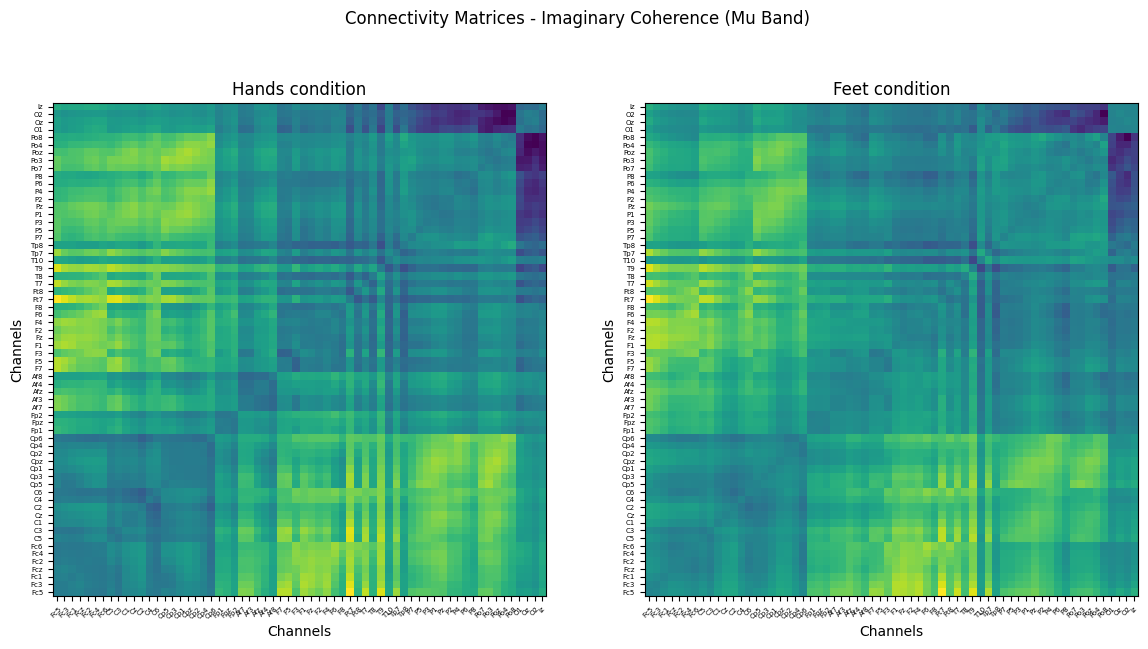

In [54]:
# Plot the connectivity for both conditions (hands and feet)
fig, ax = plt.subplots(1, 2, figsize=(14, 7))  

# Set title for the subplots
fig.suptitle('Connectivity Matrices - Imaginary Coherence (Mu Band)')
# Hands condition
im = ax[0].imshow(con_hands_data + con_hands_dataT, cmap='viridis', origin='lower')
ax[0].set_xlabel('Channels')
ax[0].set_ylabel('Channels')
ax[0].set_title('Hands condition')
ax[0].set_xticks(range(len(channel_names)))
ax[0].set_yticks(range(len(channel_names)))
ax[0].set_xticklabels(channel_names, rotation=45, fontsize= 5)
ax[0].set_yticklabels(channel_names, fontsize= 5)

# Feet condition
im = ax[1].imshow(con_feet_data + con_feet_dataT, cmap='viridis', origin='lower')
ax[1].set_xlabel('Channels')
ax[1].set_ylabel('Channels')
ax[1].set_title('Feet condition')
ax[1].set_xticks(range(len(channel_names)))
ax[1].set_yticks(range(len(channel_names)))
ax[1].set_xticklabels(channel_names, rotation=45, fontsize=5)  
ax[1].set_yticklabels(channel_names, fontsize=5)

plt.show()


Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2016 connections
    using t=-1.500s..4.500s for estimation (961 points)
    frequencies: 8.2Hz..13.0Hz (30 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Imaginary Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing 

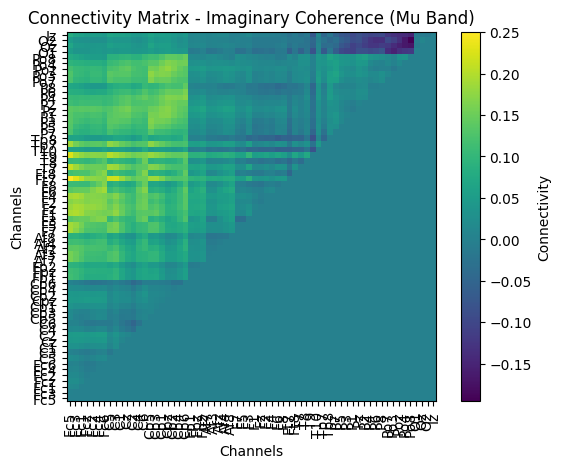

In [ ]:
fmin = 8
fmax = 13
sfreq = raw.info['sfreq']  # the sampling frequency
con_methods = ['imcoh'] # imcoh is a method for computing the imaginary part of coherency

con = spectral_connectivity_epochs(
    epochs,
    method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1) #faverage= True to average over frequencies

print(con.shape)

con_data = con.get_data()
con_data = con_data.reshape(64, 64)
# Plot the connectivity matrix
plt.imshow(con_data, cmap='viridis', origin='lower')
plt.colorbar(label='Connectivity')
plt.xlabel('Channels')
plt.ylabel('Channels')
plt.xticks(range(len(channel_names)), channel_names, rotation=90)
plt.yticks(range(len(channel_names)), channel_names)
plt.title('Connectivity Matrix - Imaginary Coherence (Mu Band)')
plt.show()

Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2016 connections
    using t=-1.500s..4.500s for estimation (961 points)
    frequencies: 8.2Hz..13.0Hz (30 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Imaginary Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing 

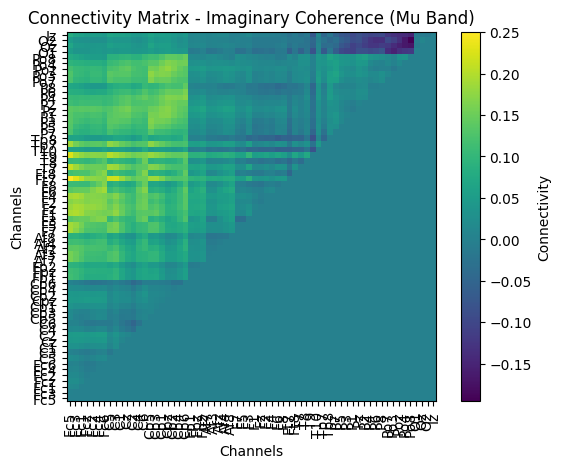

In [ ]:
fmin = 8
fmax = 13
sfreq = raw.info['sfreq']  # the sampling frequency
con_methods = ['imcoh'] # imcoh is a method for computing the imaginary part of coherency

con = spectral_connectivity_epochs(
    epochs,
    method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1) #faverage= True to average over frequencies

print(con.shape)

con_data = con.get_data()
con_data = con_data.reshape(64, 64)
# Plot the connectivity matrix
plt.imshow(con_data, cmap='viridis', origin='lower')
plt.colorbar(label='Connectivity')
plt.xlabel('Channels')
plt.ylabel('Channels')
plt.xticks(range(len(channel_names)), channel_names, rotation=90)
plt.yticks(range(len(channel_names)), channel_names)
plt.title('Connectivity Matrix - Imaginary Coherence (Mu Band)')
plt.show()

Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2016 connections
    using t=-1.500s..4.500s for estimation (961 points)
    frequencies: 8.2Hz..13.0Hz (30 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Imaginary Coherence
    computing cross-spectral density for epoch 1


    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    computing cross-spectral density for epoch 21
    asse

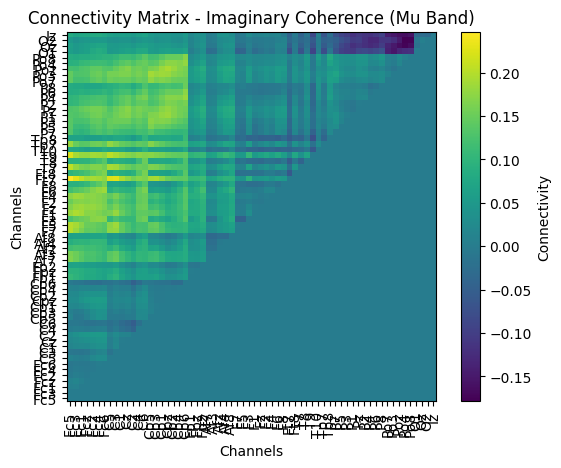

In [ ]:
fmin = 8
fmax = 13
sfreq = raw.info['sfreq']  # the sampling frequency
con_methods = ['imcoh'] # imcoh is a method for computing the imaginary part of coherency

con = spectral_connectivity_epochs(
    epochs_hands,
    method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1) #faverage= True to average over frequencies

print(con.shape)

con_data = con.get_data()
con_data = con_data.reshape(64, 64)
# Plot the connectivity matrix
plt.imshow(con_data, cmap='viridis', origin='lower')
plt.colorbar(label='Connectivity')
plt.xlabel('Channels')
plt.ylabel('Channels')
plt.xticks(range(len(channel_names)), channel_names, rotation=90)
plt.yticks(range(len(channel_names)), channel_names)
plt.title('Connectivity Matrix - Imaginary Coherence (Mu Band)')
plt.show()


Extracting EDF parameters from c:\Users\yonau\Desktop\MVA\S2\Brain functional Imaging\M2-MVA_MEEG_hands-on_materials-main\M2-MVA_MEEG_hands-on_materials-main\datasets\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from c:\Users\yonau\Desktop\MVA\S2\Brain functional Imaging\M2-MVA_MEEG_hands-on_materials-main\M2-MVA_MEEG_hands-on_materials-main\datasets\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from c:\Users\yonau\Desktop\MVA\S2\Brain functional Imaging\M2-MVA_MEEG_hands-on_materials-main\M2-MVA_MEEG_hands-on_materials-main\datasets\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R14.edf...
EDF file detected
Setting channel info structure..

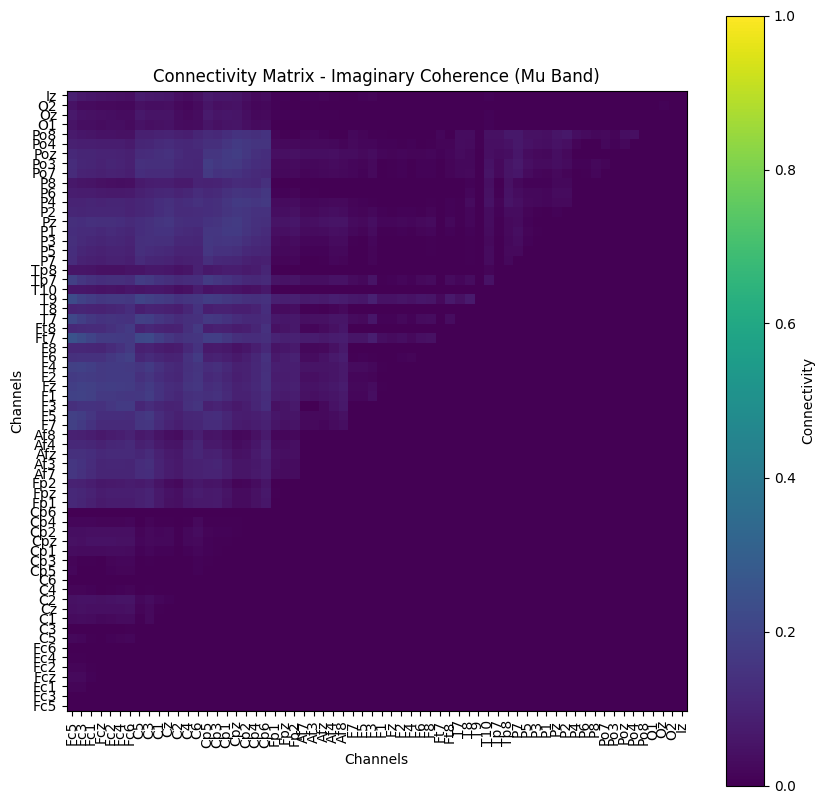

In [10]:
import numpy as np
import mne
from mne_connectivity import spectral_connectivity_epochs
import matplotlib.pyplot as plt

#Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # Motor imagery: hands vs feet
# Extract raw data
fnames = eegbci.load_data(subject=subject, runs=runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])
raw.rename_channels(lambda x: x.strip("."))  # remove dots from channel names
events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))
channel_names = raw.info['ch_names']
# Extract trials between -1s and 4s
tmin, tmax = -1, 4
event_ids = dict(hands=2, feet=3)  # map event IDs to tasks
epochs = mne.Epochs(
    raw,
    events,
    event_ids,
    tmin - 0.5,
    tmax + 0.5,
    baseline=None,
    preload=True,
)

# Sample data creation (replace this with your actual data)
sfreq = raw.info['sfreq']  # the sampling frequency
ch_names = channel_names

# Define frequency range
fmin = 8
fmax = 13
con_methods = ['imcoh']

# Compute connectivity matrices
con_obj = spectral_connectivity_epochs(
    epochs,
    method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin, tmin=tmin, tmax=tmax,
    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1
)

print(con_obj.shape)
# Access the connectivity data directly
con_data = con_obj.get_data()
con_data = con_data.reshape(64, 64)
# Normalize the connectivity matrix
norm = Normalize(vmin=0, vmax=1)

# Plot the connectivity matrix
plt.imshow(con_data, cmap='viridis', origin='lower', norm=norm) # con_data[0] 
# increase the size of the plot
plt.gcf().set_size_inches(10, 10)
plt.colorbar(label='Connectivity')
plt.xlabel('Channels')
plt.ylabel('Channels')
# add names of channels in the plot
plt.xticks(range(len(ch_names)), ch_names, rotation=90)
plt.yticks(range(len(ch_names)), ch_names)
plt.title('Connectivity Matrix - Imaginary Coherence (Mu Band)')
plt.show()





In [ ]:
from mne_connectivity import spectral_connectivity_epochs

fmin = 8
fmax = 13

method = 'imcoh'  # method for connectivity estimation

connectivity = spectral_connectivity_epochs(epochs, fmin= fmin, fmax= fmax, method=method)

connectivity = connectivity.get_data()
print(connectivity.shape)
# Plot the connectivity matrices
plt.imshow(connectivity, cmap='viridis', origin='lower')
plt.colorbar(label='Imaginary Coherence')
plt.xlabel('Channels')
plt.ylabel('Channels')
plt.title('Connectivity Matrix')
plt.show()


Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2016 connections
    using t=-1.500s..4.500s for estimation (961 points)
    frequencies: 8.2Hz..13.0Hz (30 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Imaginary Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross

In [ ]:
from mne_connectivity import spectral_connectivity_epochs

fmin = 8
fmax = 13

# Define the parameters
freq_bands = [(8, 13)]  # mu band frequency range
method = 'imcoh'  # method for connectivity estimation

# Compute connectivity matrices
connectivity_obj = spectral_connectivity_epochs(epochs, fmin=fmin, fmax=fmax, method=method)

# Access the results using methods of SpectralConnectivity
connectivity = connectivity_obj.get_data()  # Get the connectivity data

print(connectivity.shape)


Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2016 connections
    using t=-1.500s..4.500s for estimation (961 points)
    frequencies: 8.2Hz..13.0Hz (30 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Imaginary Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross

## Part 2 - Features in BCI

Here is an EEG dataset to load:

In [7]:
#Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # Motor imagery: hands vs feet

# Extract raw data
fnames = eegbci.load_data(subject=subject, runs=runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])
raw.rename_channels(lambda x: x.strip("."))  # remove dots from channel names
events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))

# Extract trials between -1s and 4s
channelsOfInterest = "T7", "C3", 'O1' # to get the full list of channels you can type: raw.info['ch_names']
tmin, tmax = -1, 4
event_ids = dict(hands=2, feet=3)  # map event IDs to tasks
epochs = mne.Epochs(
    raw,
    events,
    event_ids,
    tmin - 0.5,
    tmax + 0.5,
    picks=(channelsOfInterest),
    baseline=None,
    preload=True,
)

# Compare power spectra computed in each condition/channel 
freqs = np.arange(2, 45)
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

# Time-Frequency decomposition
tfr = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

nb_channels = len(channelsOfInterest)
for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

Extracting EDF parameters from /Users/marie-constance.corsi/Documents/GitHub/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/marie-constance.corsi/Documents/GitHub/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/marie-constance.corsi/Documents/GitHub/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T1', 'T2']
Not setting metad


Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.724718
stat_fun(H1): min=-4.067712 max=3.432081
Running initial clustering
Found 96 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.724718
stat_fun(H1): min=-8.523637 max=3.419585
Running initial clustering
Found 112 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.724718
stat_fun(H1): min=-8.523637 max=3.419585
Running initial clustering
Found 84 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.724718
stat_fun(H1): min=-6.355431 max=5.751019
Running initial clustering
Found 150 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.724718
stat_fun(H1): min=-6.355431 max=5.751019
Running initial clustering
Found 77 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.713872
stat_fun(H1): min=-5.676877 max=3.052649
Running initial clustering
Found 61 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.713872
stat_fun(H1): min=-5.676877 max=3.052649
Running initial clustering
Found 80 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.713872
stat_fun(H1): min=-3.687815 max=3.369164
Running initial clustering
Found 111 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.713872
stat_fun(H1): min=-3.687815 max=3.369164
Running initial clustering
Found 105 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.713872
stat_fun(H1): min=-3.619173 max=3.517158
Running initial clustering
Found 133 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.713872
stat_fun(H1): min=-3.619173 max=3.517158
Running initial clustering
Found 59 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


## Questions: 
- Please describe the observations you can make from the maps. Are there neurophysiologically relevant/meaningful?
- To what extent such observations are informative of BCI performance?
- If you were the experimenter, based on the previous observations, which (electrode(s); frequency bin(s)) couples would you pick to extract the features? Why?

## Part 3 - Machine Learning & BCI

## Context

Here is a publicly available [BCI dataset](http://moabb.neurotechx.com/docs/generated/moabb.datasets.BNCI2014_001.html#moabb.datasets.BNCI2014_001) (cf below to load the data and to get information regarding the experimental information). In the following lines of code we defined two classification pipelines (CSP+LDA: Common Spatial Patterns + LDA, RG+LR:Riemannian Geometry + Logistic Regression), and we plotted their performances from a dataset composed of 2 subjects.

## Questions
- What observations can be made from the plots? 
- Instead of those implemented here, what framework would you propose to extract, select, and classify the features? Why? How would you assess the performance of your approach?

## BONUS
- Implement below your framework and compare it to the other pipelines (namely RG+LR and CSP+LDA). 
- What are your conclusions? Do you have some suggestion(s) to improve the performance of your framework?

In [8]:
import warnings

from mne.decoding import CSP
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import BNCI2014001 # note: if you use MOABB>1.1, please change it as BNCI2014_001
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import LeftRightImagery

moabb.set_log_level("info")
mne.set_log_level("CRITICAL")
warnings.filterwarnings("ignore")


###### PIPELINES TO BE COMPARED (do not modify it!) ######
# baseline pipeline to be used to make the comparison, please complete the following line with your framework
pipelines = {}
pipelines["CSP+LDA"] = make_pipeline(CSP(n_components=8), LDA())
pipelines["RG+LR"] = make_pipeline(
    Covariances(), TangentSpace(), LogisticRegression(solver="lbfgs")
)
### BONUS - implementation of your framework ######
#pipelines["MyPipeline"] =


###### DATASET TO BE USED (do not modify it!) - downloading it the first time can take some time ######
dataset = BNCI2014001() # if you are using a more recent version of moabb please change it as BNCI2014_001
subj = [1, 2]
dataset.subject_list = subj


###### DEFINITION OF THE PARADIGM & EVALUATION (do not modify it!) ######
paradigm = LeftRightImagery()
evaluation = WithinSessionEvaluation(
    paradigm=paradigm, datasets=dataset, overwrite=False
)
results = evaluation.process(pipelines)
#print(results.head()) # if you want to look at it...


2024-01-25 12:16:47,670 INFO MainThread moabb.evaluations.base Processing dataset: 001-2014


In [9]:
###### SCRIPT TO PLOT THE RESULTS (do not modify it unless you want to add your framework!) #########

# Plot the global distribution of the performance
fig, axes = plt.subplots(1, 2, figsize=[8, 4], sharey=True)

sns.stripplot(
    data=results,
    y="score",
    x="pipeline",
    ax=axes[0],
    jitter=True,
    alpha=0.5,
    zorder=1,
    palette="rocket",
)
sns.pointplot(data=results, y="score", x="pipeline", ax=axes[0], palette="rocket")

axes[0].set_ylabel("ROC AUC")
axes[0].set_ylim(0.5, 1)

paired = results.pivot_table(
    values="score", columns="pipeline", index=["subject", "session"]
)
paired = paired.reset_index()

sns.regplot(data=paired, y="RG+LR", x="CSP+LDA", ax=axes[1], fit_reg=False)
axes[1].plot([0, 1], [0, 1], ls="--", c="k")
axes[1].set_xlim(0.5, 1)

plt.show()

# Plot the individual distribution of the performance
g = sns.catplot(
    kind="bar",
    x="score",
    y="subject",
    hue="pipeline",
    col="dataset",
    height=12,
    aspect=0.5,
    data=results,
    orient="h",
    palette="rocket",
)
plt.show()

## Part 4 - Experimental considerations

You plan to launch a new protocol based on EEG acquisitions:
- What are the two main types of artifacts you may observe? Please indicate one example for each of them.
- What are the main steps that compose an EEG processing pipeline?

Now you are conducting and experimental protocol in BCI. It consists in 5 sessions of right hand motor imagery vs rest. After the fourth session training sessions subject Y still shows a global performance of 60%. 
At each session:
- You instructed the subject to perform a right motor imagery when the visual target was up and to remain at rest when the visual target was down.
- You always selected the same features (power spectra in CP3 at 10Hz & 14Hz, and in C3 at 12Hz & 16Hz).

Based on these elements, what would be your suggestions to help the subject Y improving their performance at session 5?